In [132]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import gpxpy
#import gpx.gpx
import geopy.distance
import folium

In [133]:
maxlean, accel, topspeed = 45, 4, 180 # aggressive values

In [134]:
# import gps coordinates for route from gpx file exported from google maps & converter
gpx = gpxpy.parse(open('test_track.gpx','r'))
points = []
for track in gpx.tracks:
    for segment in track.segments:        
        for point in segment.points:
            points.append([point.latitude, point.longitude])
points = np.array(points)
points

array([[  40.7441969,  -73.980417 ],
       [  40.7445   ,  -73.98111  ],
       [  40.74463  ,  -73.98143  ],
       ...,
       [  33.8444959, -118.3966897],
       [  33.84463  , -118.39676  ],
       [  33.8446342, -118.3967569]])

In [135]:
# calculat#e curvature of road based on sampling 3 points and calculating radius of circle intersecting all
delta = 3

curvature = np.zeros_like(points[:,0])

for i in range(delta,len(points)-2*delta-1):
    a = math.sqrt(np.sum((points[i-delta] - points[i])**2))
    b = math.sqrt(np.sum((points[i] - points[i+delta])**2))
    c = math.sqrt(np.sum((points[i-delta] - points[i+delta])**2))
    if a*b*c > 0 and a+b-c>0:
        cosangle = (a**2 + b**2 - c**2) /(2*a*b)
        try:
            sinangle = math.sqrt(1 - cosangle**2)
            radius = c / sinangle
        except: pass
    scale = geopy.distance.distance(points[i], points[i+delta]).m / b
    curvature[i] = radius * scale


In [136]:
# calculate theoretical top speed for each stretch of road based on max lean angle and acceleration
topspeed *= 0.44704
max_vel = np.zeros_like(curvature)

cornering_accel = 9.81 * np.tan(maxlean * np.pi / 180)
r_min = cornering_accel**2/topspeed**2

for i in range(len(curvature)):
    max_vel[i] = cornering_accel * np.sqrt(curvature[i])/2
max_vel[max_vel > topspeed] = topspeed
max_vel[max_vel < 3] = 3
max_vel

array([3., 3., 3., ..., 3., 3., 3.])

In [137]:
# iterate simulation to determine actual top speed for each stretch of road
braking_dist = topspeed**2 / (2*accel)
vel = np.ones_like(max_vel)

# calculate distances between points
next_dist = np.zeros_like(max_vel)
for i in range(len(points)-1):
    next_dist[i] = geopy.distance.distance(points[i], points[i+1]).m

for i in range(len(points)-1):
    # determine how far ahead to look on route and determine info
    point_search = 0
    cum_dist = 0
    while cum_dist < braking_dist and i+point_search < len(points):
        cum_dist += next_dist[i + point_search]
        point_search += 1
    max_vel_distro = [max_vel[i+j] for j in range(point_search)]
    dist_distro = np.cumsum([next_dist[i+j] for j in range(point_search)])
    
    # determine action (brake or accelerate)
    future_action = np.zeros_like(dist_distro)
    BRAKE = False
    for j in range(len(max_vel_distro)):
        if dist_distro[j] == 0:
            future_action[j] = 0
        else:
            future_action[j] = (max_vel_distro[j]**2 - vel[i]**2) / (2*dist_distro[j])
        
        if future_action[j] <= -0.9*accel:
            BRAKE = True
    if BRAKE:
        vel[i+1] = vel[i] - accel
    elif future_action[0] > accel:
            vel[i+1] = vel[i] + accel
    else:
        vel[i+1] = vel[i] + future_action[0]
    
    # limit speed to topspeed
    if vel[i+1] >= topspeed:
        vel[i+1] = topspeed

Input Parameters:
    180 mph top speed
    4 m/s² acceleration
    25 ° max lean
    3 point delta
Distance: 2805.912 mi
Time: 15 : 56 : 10.86
Speed: Avg. 176.31   Max: 177.0
208294 GPS points on route


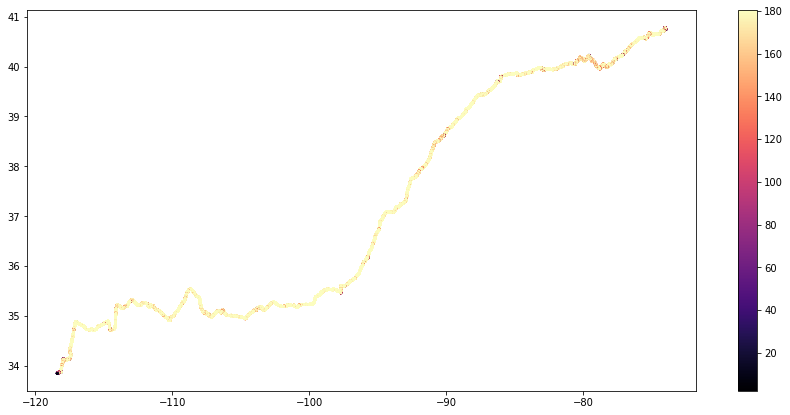

In [138]:
print('Input Parameters:\n   ', round(topspeed*2.24), 'mph top speed\n   ',
      round(accel), 'm/s² acceleration\n   ',
      round(maxlean), '° max lean\n   ',
      delta, 'point delta')
print('Distance:', np.round(np.sum(next_dist)/1609.34,3),'mi')

sec = np.sum(next_dist/vel)
print('Time:', int(sec//60//60),':', int(sec//60%60),':', np.round(sec%60, 2))
print('Speed: Avg.', np.round(np.sum(next_dist)/sec*2.24,2), '  Max:', np.round(max(vel)*2.2))
print(len(points), 'GPS points on route')

l = 0
h = -1


plt.figure(figsize=(15,7)) # set size of figure
plt.scatter(points[l:h,1], points[l:h,0], c=vel[l:h]*2.24, s=3, cmap='magma')
plt.colorbar();

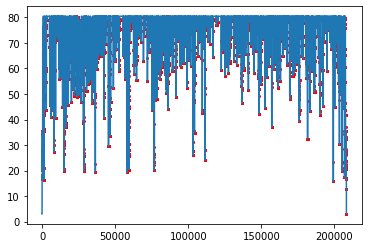

In [139]:
#def SMA(v, n=3):
#  con = np.concatenate([np.linspace(0,1,n//2)[:-1],np.linspace(1,0,n//2)])*2/n
#  return np.convolve(v, con, 'valid')
n = 100
lst1 = pd.Series(max_vel).rolling(n).min().dropna().tolist()

corners = []
corners_vel = []

for i in range(len(lst1)):
    if lst1[i] != max_vel[i]:
        corners.append(i)
        corners_vel.append(lst1[i])

plt.plot(lst1)
plt.scatter(corners, corners_vel,s=4, c='r')

